In [1]:
%pylab inline
import scipy, scipy.misc, scipy.stats

Populating the interactive namespace from numpy and matplotlib


Some basic formulas and definitions:
- MTBF = mean time between failures (time unit T per failure)
- &lambda; = failures per time unit T (mean over many identical components)
- F = failure rate or probability of failure in time unit T
- R = reliability rate (probability of working in time unit T)

Convertions:

- $\lambda = T / MTFB$
- $F = \lambda / T = 1 / MTBF$
- $R = 1 - F$

T is the time unit over which we calculate, usually years.

E.g.: if component has 2 failures per 10 years, then $\lambda = 0.2, MTBF = 5 \mathrm{Years}, F = 0.2, R = 0.8$

That is, the probably of failure within one year is 0.2.

It's important to note that &lambda; is a statistical mean (average) of failures of many components; If you operate a single such component for 10 years you may have 0 failures, or 1 or even 5. The probability follows a binomial distribution:

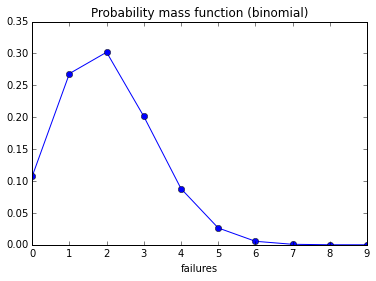

In [2]:
years = 10
f = 0.2
k_failures_vec = arange(0, years, 1)

pmf = scipy.stats.binom.pmf(k_failures_vec, years, f)
plt.xlabel('failures')
plt.title('Probability mass function (binomial)')
plt.plot(k_failures_vec, pmf, marker='o')

In [3]:
def r_to_mtbf(r):
    return 1 / (1 - r)

The reliability of a parallel system can be computed by the formula:
$$R_{total} = \sum_{i=0}^{k} \binom{n}{k} R^{i} F^{n-i}$$

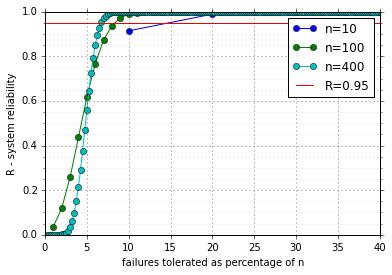

In [4]:
def r_prob(r, n, k):
    """The reliability of parallel system with n component that can tolerate up to k failures
    """
    return sum([scipy.misc.comb(n, i)*(1-r)**i*r**(n-i) for i in range(0,k+1)])

vec_r_prob = np.vectorize(r_prob)

ax = plt.subplot(111)
r = 0.95

for n, color in [(10, 'b'), (100, 'g'), (400, 'c')]:
    x = np.linspace(1, n, n, dtype='int')
    ax.plot(x / float(n) * 100, vec_r_prob(r, n, x), label='n=%d' % n, color=color, marker='o')

# plot formatting stuff, not really interesting
ax.axhline(r, color='r', label='R=%0.2f' % r)
ax.legend()
ax.set_xlabel('failures tolerated as percentage of n')
ax.set_ylabel('R - system reliability')
ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, 0.05), minor=True)
ax.set_xticks(np.arange(0, 101, 5), minor=True)
ax.tick_params(which = 'both', direction = 'out')
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 40)
ax.grid(which='major', alpha=0.7)
ax.grid(which='minor', alpha=0.3)

From the above graph we can see that as n grows we need smaller redundancy to achieve the same reliability. With 10 machines we need 20% redundancy to be more reliable than a single node, with 100 only 9% and with 400 nodes only 6% redudancy.
We can also see that with small redudancy reliability actually *decreases*, because there are more options for failure.

In [5]:
for r, n, k in [(0.95, 10, 2), (0.99, 10, 2)]:
    r_total = r_prob(r, n, k)
    print "r_comp=%.2f, mtbf_comp=%d, r_total=%.4f, mtbf_total=%d" % (r, r_to_mtbf(r), r_total, r_to_mtbf(r_total))


r_comp=0.95, mtbf_comp=19, r_total=0.9885, mtbf_total=86
r_comp=0.99, mtbf_comp=99, r_total=0.9999, mtbf_total=8783


From this we see that redundancy acts as a multiplier on component MTBF - improving component MTBF by a factor of 5 improves total MTBF by a factor of 100!
So redudancy will have higher ROI if your components are already reliable.